In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
accuracy_score,
confusion_matrix,
f1_score,
recall_score,
classification_report,
roc_auc_score,
roc_curve
)

warnings.filterwarnings('ignore')

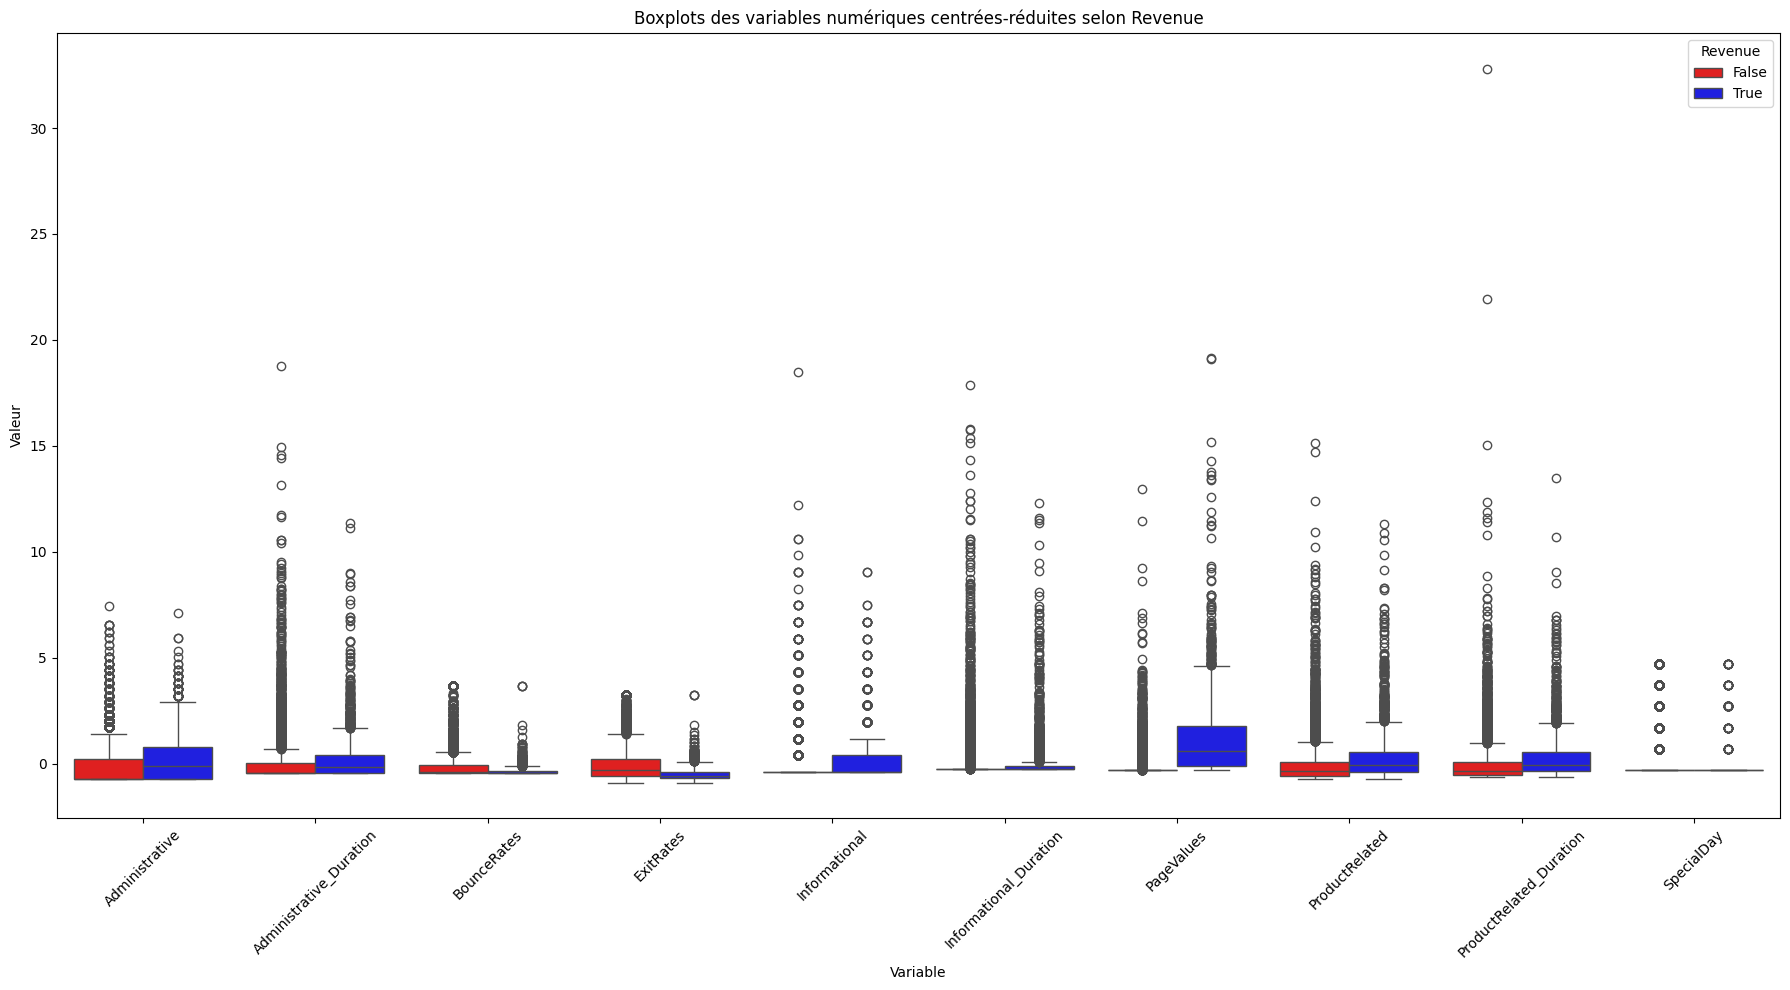

In [2]:


# Chargement des données
os.getcwd()
df_source = pd.read_csv("online_shoppers_intention.csv", sep=",")

# Sélection des colonnes numériques (hors 'Revenue')
numeric_cols = df_source.select_dtypes(include=np.number).columns

# Liste des variables catégorielles à exclure
# (celles qui ne sont pas des vraies variables numériques)
var_categ_num = ['OperatingSystems','Browser','Region','TrafficType']

#liste des variables catégorielles à dummiser
var_categ = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']

# Suppression des valeurs spécifiques
numeric_cols = numeric_cols.difference(var_categ_num)
# Centrage et réduction des variables numériques
scaler = StandardScaler()
df_scaled = df_source.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# On sélectionne uniquement les colonnes numériques et la cible 'Revenue'
cols_to_plot = list(numeric_cols) + ['Revenue']
df_plot = df_scaled[cols_to_plot].copy()

# On transforme Revenue en booléen si ce n'est pas déjà le cas
df_plot['Revenue'] = df_plot['Revenue'].astype(bool)

# Création du format long pour faciliter le tracé des boxplots groupés
df_long = pd.melt(df_plot, id_vars='Revenue', var_name='Variable', value_name='Valeur')

# Affichage des boxplots pour chaque variable numérique, groupés par Revenue
plt.figure(figsize=(18, 10))
sns.boxplot(data=df_long, x='Variable', y='Valeur', hue='Revenue', palette={False: 'red', True: 'blue'})
plt.xticks(rotation=45)
plt.title("Boxplots des variables numériques centrées-réduites selon Revenue")
plt.legend(title='Revenue')
plt.tight_layout()
plt.show()

In [3]:
df_scaled.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,Feb,1,1,1,1,Returning_Visitor,False,False
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,Feb,2,2,1,2,Returning_Visitor,False,False
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,Feb,4,1,9,3,Returning_Visitor,False,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,Feb,3,2,2,4,Returning_Visitor,False,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df_source[numeric_cols].describe()

,Administrative,Administrative_Duration,BounceRates,ExitRates,Informational,Informational_Duration,PageValues,ProductRelated,ProductRelated_Duration,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.022191,0.043073,0.503569,34.472398,5.889258,31.731468,1194.746220,0.061427
std,3.321784,176.779107,0.048488,0.048597,1.270156,140.749294,18.568437,44.475503,1913.669288,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000
50%,1.000000,7.500000,0.003112,0.025156,0.000000,0.000000,0.000000,18.000000,598.936905,0.000000
75%,4.000000,93.256250,0.016813,0.050000,0.000000,0.000000,0.000000,38.000000,1464.157214,0.000000
max,27.000000,3398.750000,0.200000,0.200000,24.000000,2549.375000,361.763742,705.000000,63973.522230,1.000000


In [5]:
print(df_source["Revenue"].value_counts())
print(10422 / (10422 + 1234)*100)  # Proportion de Revenue = True


Revenue
False    10422
True      1908
Name: count, dtype: int64
89.41317776252575


In [6]:
print(df_scaled["Month"].value_counts())

Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64


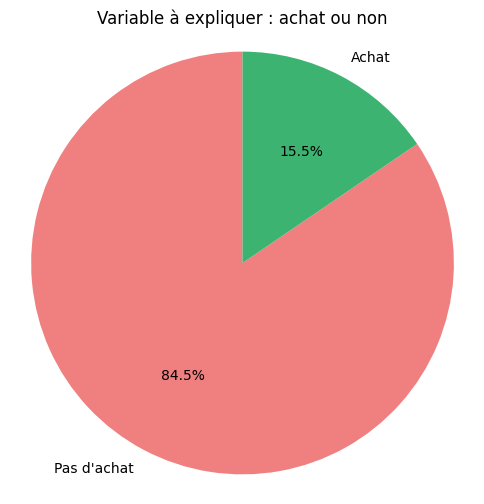

In [7]:
revenue_counts = df_source['Revenue'].value_counts()
labels = ['Pas d\'achat', 'Achat']
sizes = [revenue_counts[False], revenue_counts[True]]
colors = ['lightcoral', 'mediumseagreen']

# Diagramme
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Variable à expliquer : achat ou non")
plt.axis('equal')
plt.show()

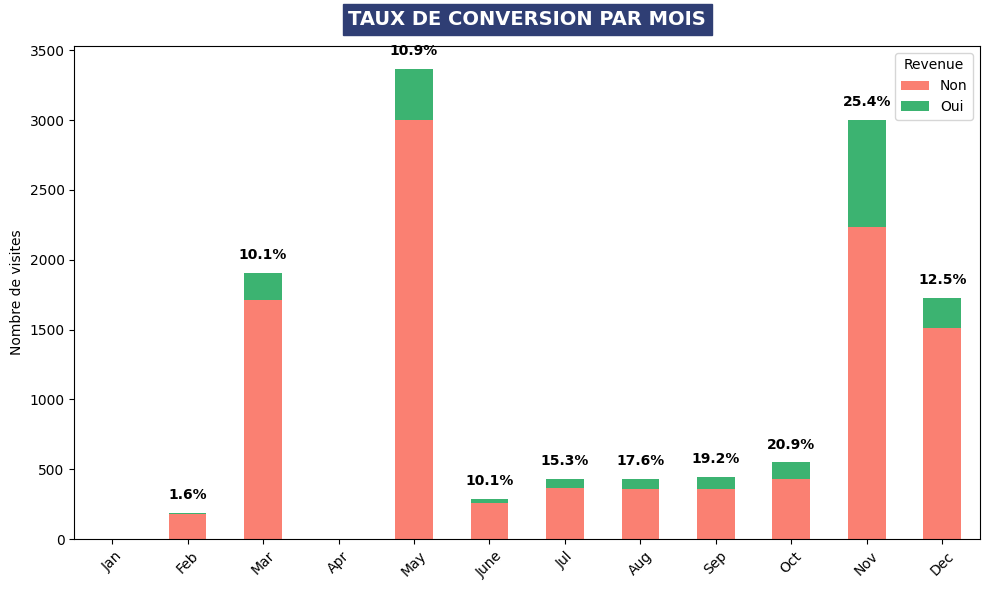

In [8]:
df_source['Revenue'] = df_source['Revenue'].map({True: 'Oui', False: 'Non'})

# Comptage par mois et revenue
counts = df_source.groupby(['Month', 'Revenue']).size().unstack(fill_value=0)

# Calcul des pourcentages pour affichage
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Tris des mois dans l'ordre logique
mois_ordre = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
counts = counts.reindex(mois_ordre)

# Plot
ax = counts.plot(kind='bar', stacked=True, color=['salmon', 'mediumseagreen'], figsize=(10,6))

# Ajouter les pourcentages au-dessus des barres
for i, month in enumerate(counts.index):
    total = counts.loc[month].sum()
    if total > 0:
        pct = percentages.loc[month, 'Oui']
        ax.text(i, total + 100, f'{pct:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Légendes et titres
plt.title("TAUX DE CONVERSION PAR MOIS", fontsize=14, fontweight='bold', backgroundcolor='#2f3e74', color='white', pad=15)
plt.xlabel("")
plt.ylabel("Nombre de visites")
plt.xticks(rotation=45)
plt.legend(title="Revenue")
plt.tight_layout()
plt.show()

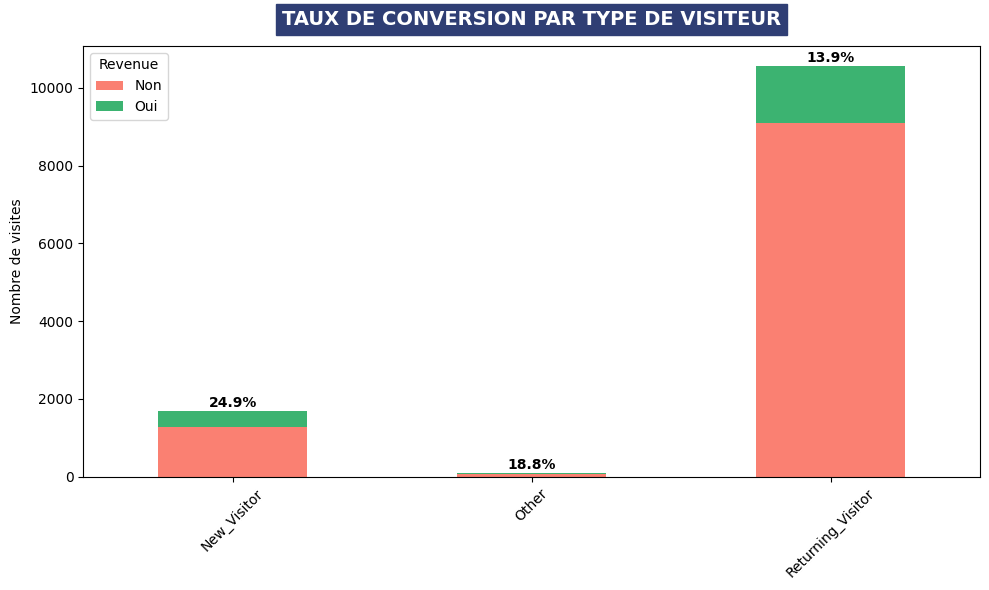

In [9]:
# Comptage par mois et revenue
counts = df_source.groupby(['VisitorType', 'Revenue']).size().unstack(fill_value=0)

# Calcul des pourcentages pour affichage
percentages = counts.div(counts.sum(axis=1), axis=0) * 100


# Plot
ax = counts.plot(kind='bar', stacked=True, color=['salmon', 'mediumseagreen'], figsize=(10,6))

# Ajouter les pourcentages au-dessus des barres
for i, month in enumerate(counts.index):
    total = counts.loc[month].sum()
    if total > 0:
        pct = percentages.loc[month, 'Oui']
        ax.text(i, total + 100, f'{pct:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Légendes et titres
plt.title("TAUX DE CONVERSION PAR TYPE DE VISITEUR", fontsize=14, fontweight='bold', backgroundcolor='#2f3e74', color='white', pad=15)
plt.xlabel("")
plt.ylabel("Nombre de visites")
plt.xticks(rotation=45)
plt.legend(title="Revenue")
plt.tight_layout()
plt.show()

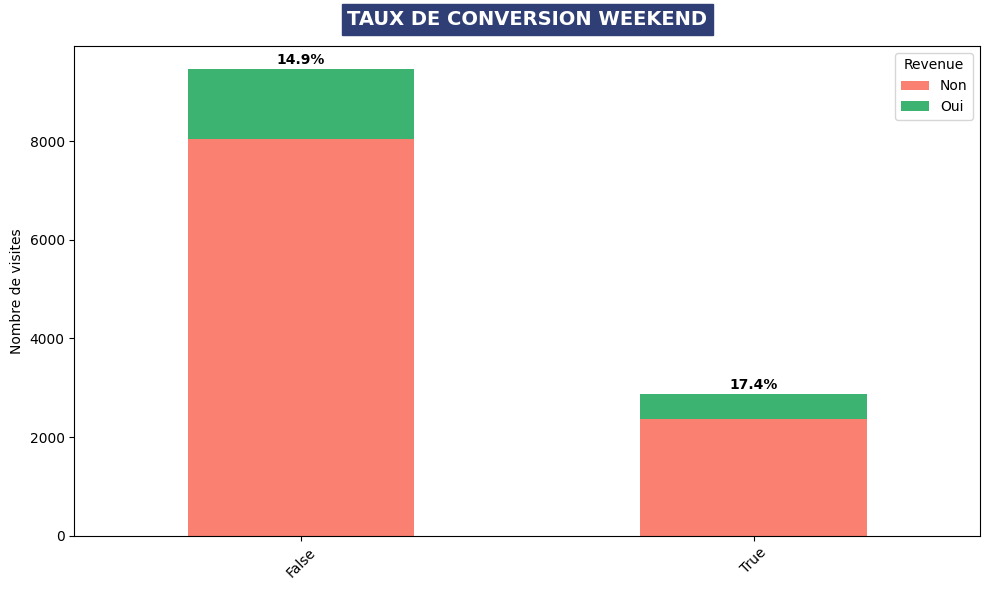

In [10]:
# Comptage par mois et revenue
counts = df_source.groupby(['Weekend', 'Revenue']).size().unstack(fill_value=0)

# Calcul des pourcentages pour affichage
percentages = counts.div(counts.sum(axis=1), axis=0) * 100


# Plot
ax = counts.plot(kind='bar', stacked=True, color=['salmon', 'mediumseagreen'], figsize=(10,6))

# Ajouter les pourcentages au-dessus des barres
for i, month in enumerate(counts.index):
    total = counts.loc[month].sum()
    if total > 0:
        pct = percentages.loc[month, 'Oui']
        ax.text(i, total + 100, f'{pct:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Légendes et titres
plt.title("TAUX DE CONVERSION WEEKEND", fontsize=14, fontweight='bold', backgroundcolor='#2f3e74', color='white', pad=15)
plt.xlabel("")
plt.ylabel("Nombre de visites")
plt.xticks(rotation=45)
plt.legend(title="Revenue")
plt.tight_layout()
plt.show()


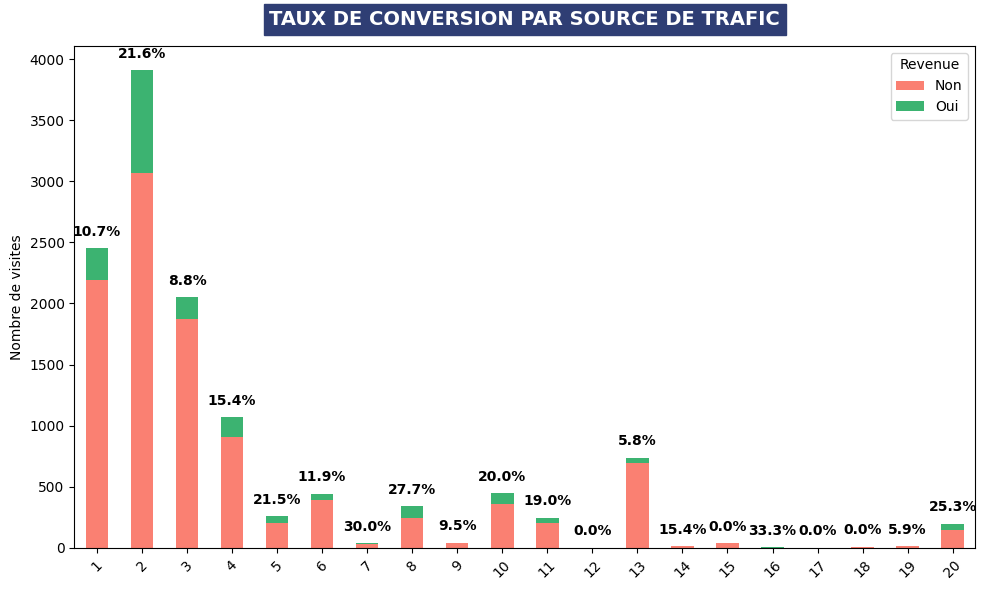

In [11]:
# Comptage par mois et revenue
counts = df_source.groupby(['TrafficType', 'Revenue']).size().unstack(fill_value=0)

# Calcul des pourcentages pour affichage
percentages = counts.div(counts.sum(axis=1), axis=0) * 100


# Plot
ax = counts.plot(kind='bar', stacked=True, color=['salmon', 'mediumseagreen'], figsize=(10,6))

# Ajouter les pourcentages au-dessus des barres
for i, month in enumerate(counts.index):
    total = counts.loc[month].sum()
    if total > 0:
        pct = percentages.loc[month, 'Oui']
        ax.text(i, total + 100, f'{pct:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Légendes et titres
plt.title("TAUX DE CONVERSION PAR SOURCE DE TRAFIC", fontsize=14, fontweight='bold', backgroundcolor='#2f3e74', color='white', pad=15)
plt.xlabel("")
plt.ylabel("Nombre de visites")
plt.xticks(rotation=45)
plt.legend(title="Revenue")
plt.tight_layout()
plt.show()

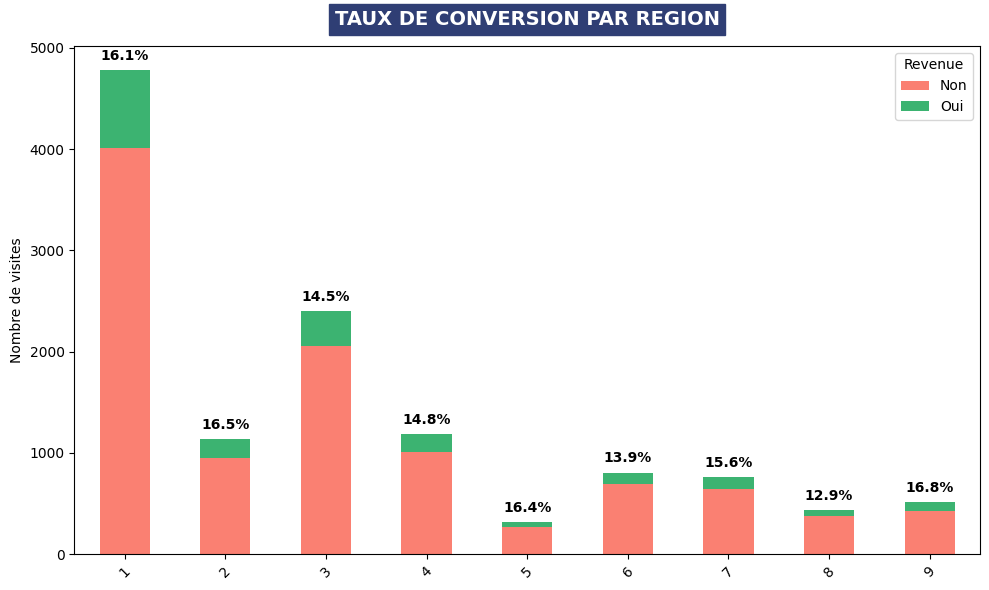

In [12]:
# Comptage par mois et revenue
counts = df_source.groupby(['Region', 'Revenue']).size().unstack(fill_value=0)

# Calcul des pourcentages pour affichage
percentages = counts.div(counts.sum(axis=1), axis=0) * 100


# Plot
ax = counts.plot(kind='bar', stacked=True, color=['salmon', 'mediumseagreen'], figsize=(10,6))

# Ajouter les pourcentages au-dessus des barres
for i, month in enumerate(counts.index):
    total = counts.loc[month].sum()
    if total > 0:
        pct = percentages.loc[month, 'Oui']
        ax.text(i, total + 100, f'{pct:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Légendes et titres
plt.title("TAUX DE CONVERSION PAR REGION", fontsize=14, fontweight='bold', backgroundcolor='#2f3e74', color='white', pad=15)
plt.xlabel("")
plt.ylabel("Nombre de visites")
plt.xticks(rotation=45)
plt.legend(title="Revenue")
plt.tight_layout()
plt.show()

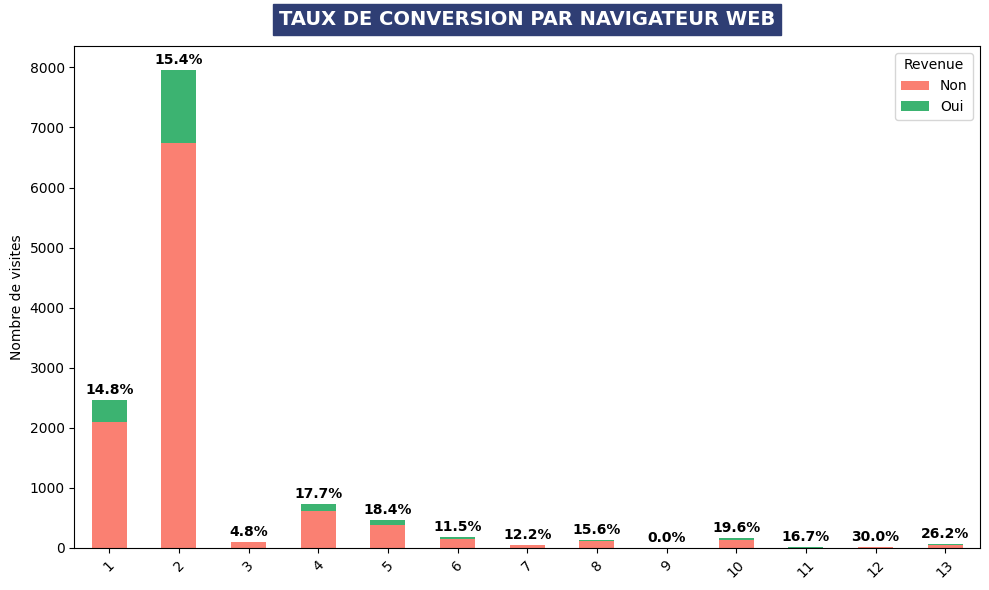

In [13]:
# Comptage par mois et revenue
counts = df_source.groupby(['Browser', 'Revenue']).size().unstack(fill_value=0)

# Calcul des pourcentages pour affichage
percentages = counts.div(counts.sum(axis=1), axis=0) * 100


# Plot
ax = counts.plot(kind='bar', stacked=True, color=['salmon', 'mediumseagreen'], figsize=(10,6))

# Ajouter les pourcentages au-dessus des barres
for i, month in enumerate(counts.index):
    total = counts.loc[month].sum()
    if total > 0:
        pct = percentages.loc[month, 'Oui']
        ax.text(i, total + 100, f'{pct:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Légendes et titres
plt.title("TAUX DE CONVERSION PAR NAVIGATEUR WEB", fontsize=14, fontweight='bold', backgroundcolor='#2f3e74', color='white', pad=15)
plt.xlabel("")
plt.ylabel("Nombre de visites")
plt.xticks(rotation=45)
plt.legend(title="Revenue")
plt.tight_layout()
plt.show()

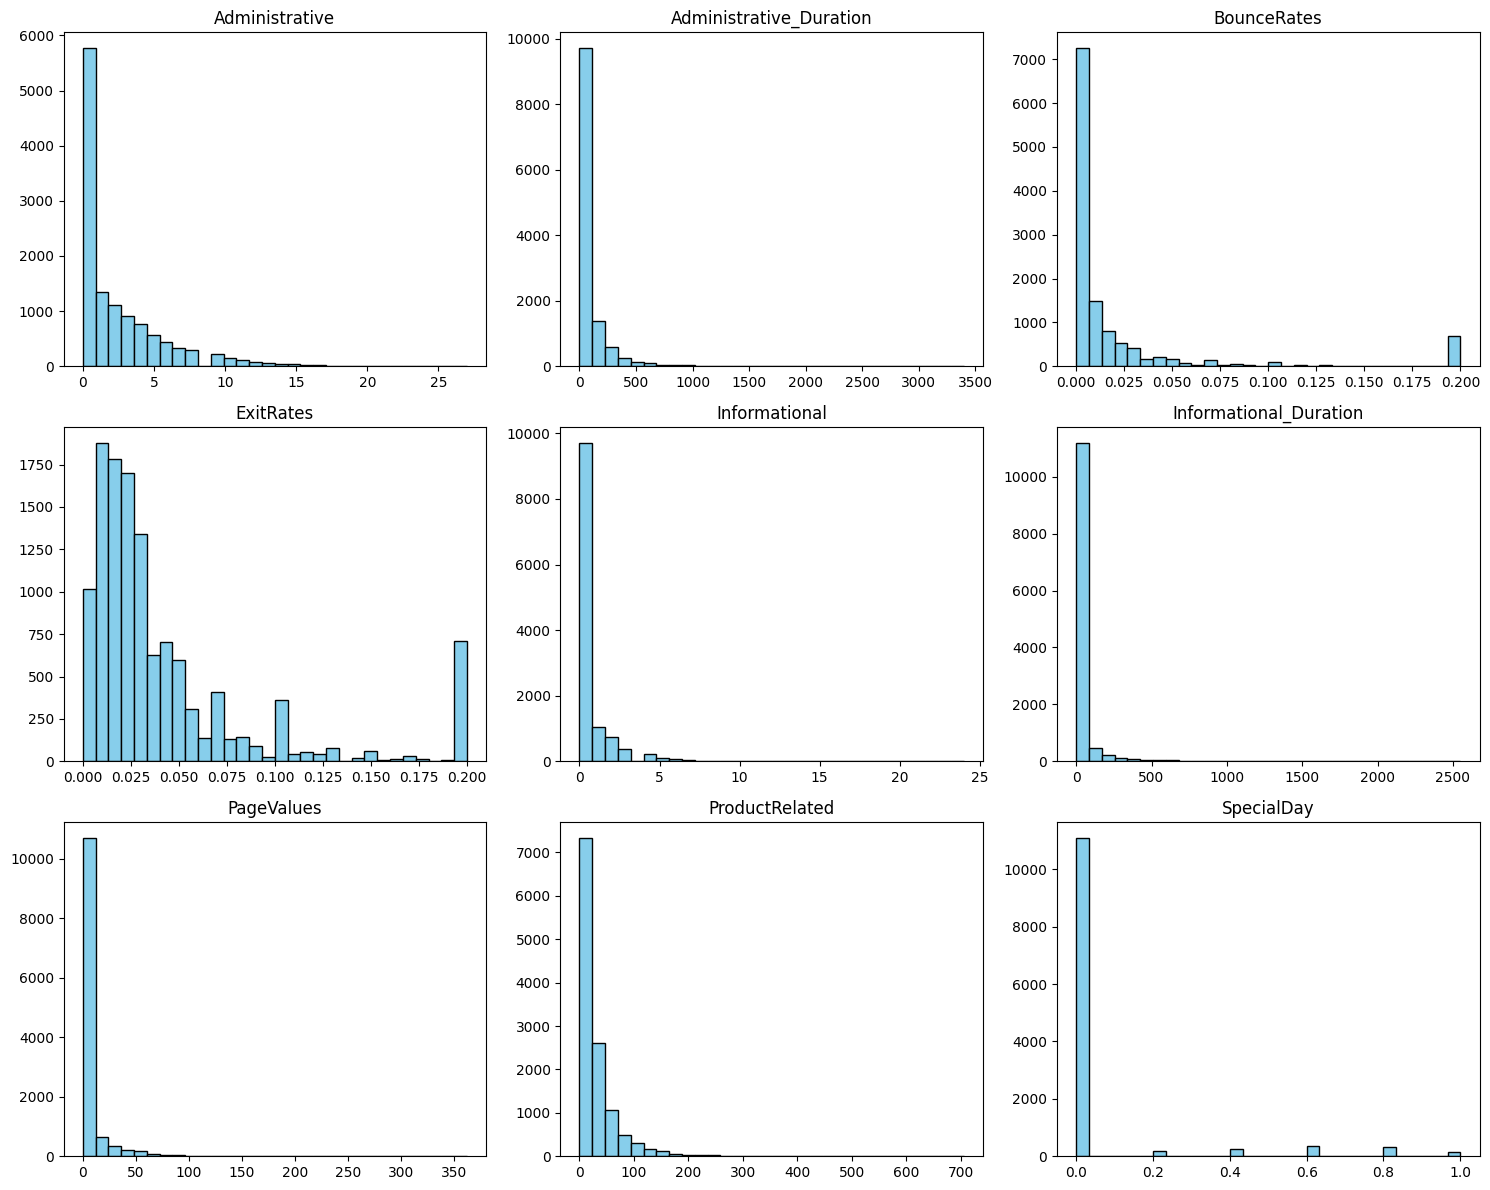

In [14]:

# Liste des variables à afficher (hors ProductRelated_Duration si besoin)
vars_hist = [col for col in numeric_cols if col != 'ProductRelated_Duration']

n = len(vars_hist)
ncols = 3
nrows = math.ceil(n / ncols)

plt.figure(figsize=(5 * ncols, 4 * nrows))
for i, col in enumerate(vars_hist, 1):
    plt.subplot(nrows, ncols, i)
    plt.hist(df_source[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.tight_layout()
plt.show()

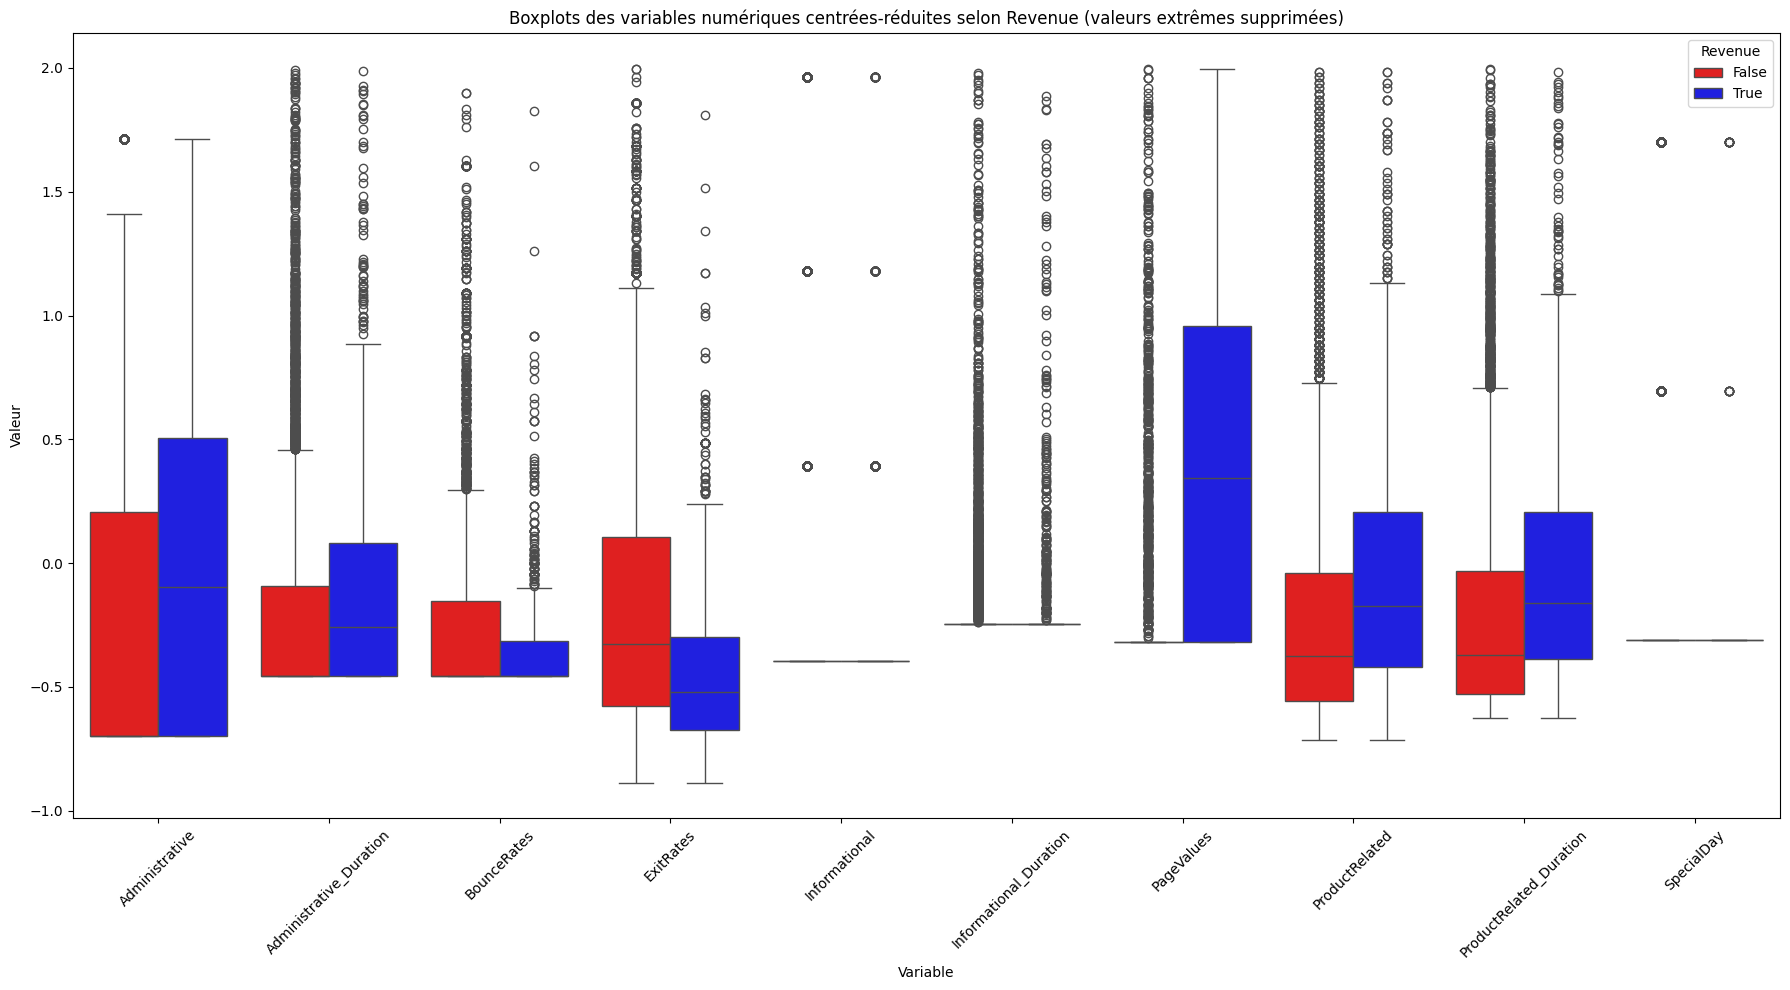

In [15]:
# Suppression des individus dont au moins une variable numérique centrée-réduite > moyenne + 2*écart-type (soit > 2)
df_filtered = df_scaled[(df_scaled[numeric_cols] <= 2).all(axis=1)].copy()

# On sélectionne uniquement les colonnes numériques et la cible 'Revenue'
cols_to_plot = list(numeric_cols) + ['Revenue']
df_plot = df_filtered[cols_to_plot].copy()
df_plot['Revenue'] = df_plot['Revenue'].astype(bool)

# Format long pour boxplots groupés
df_long = pd.melt(df_plot, id_vars='Revenue', var_name='Variable', value_name='Valeur')

# Affichage des boxplots
plt.figure(figsize=(18, 10))
sns.boxplot(data=df_long, x='Variable', y='Valeur', hue='Revenue', palette={False: 'red', True: 'blue'})
plt.xticks(rotation=45)
plt.title("Boxplots des variables numériques centrées-réduites selon Revenue (valeurs extrêmes supprimées)")
plt.legend(title='Revenue')
plt.tight_layout()
plt.show()

In [16]:
df_filtered.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,Feb,2,2,1,2,Returning_Visitor,False,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,Feb,3,2,2,4,Returning_Visitor,False,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,Feb,3,3,1,4,Returning_Visitor,True,False
5,-0.696993,-0.457191,-0.396478,-0.244931,-0.286270,-0.543757,-0.132035,-0.380935,-0.317178,-0.308821,Feb,2,2,1,3,Returning_Visitor,False,False
9,-0.696993,-0.457191,-0.396478,-0.244931,-0.646033,-0.238685,-0.457683,-0.429072,-0.317178,1.702146,Feb,2,4,1,2,Returning_Visitor,False,False


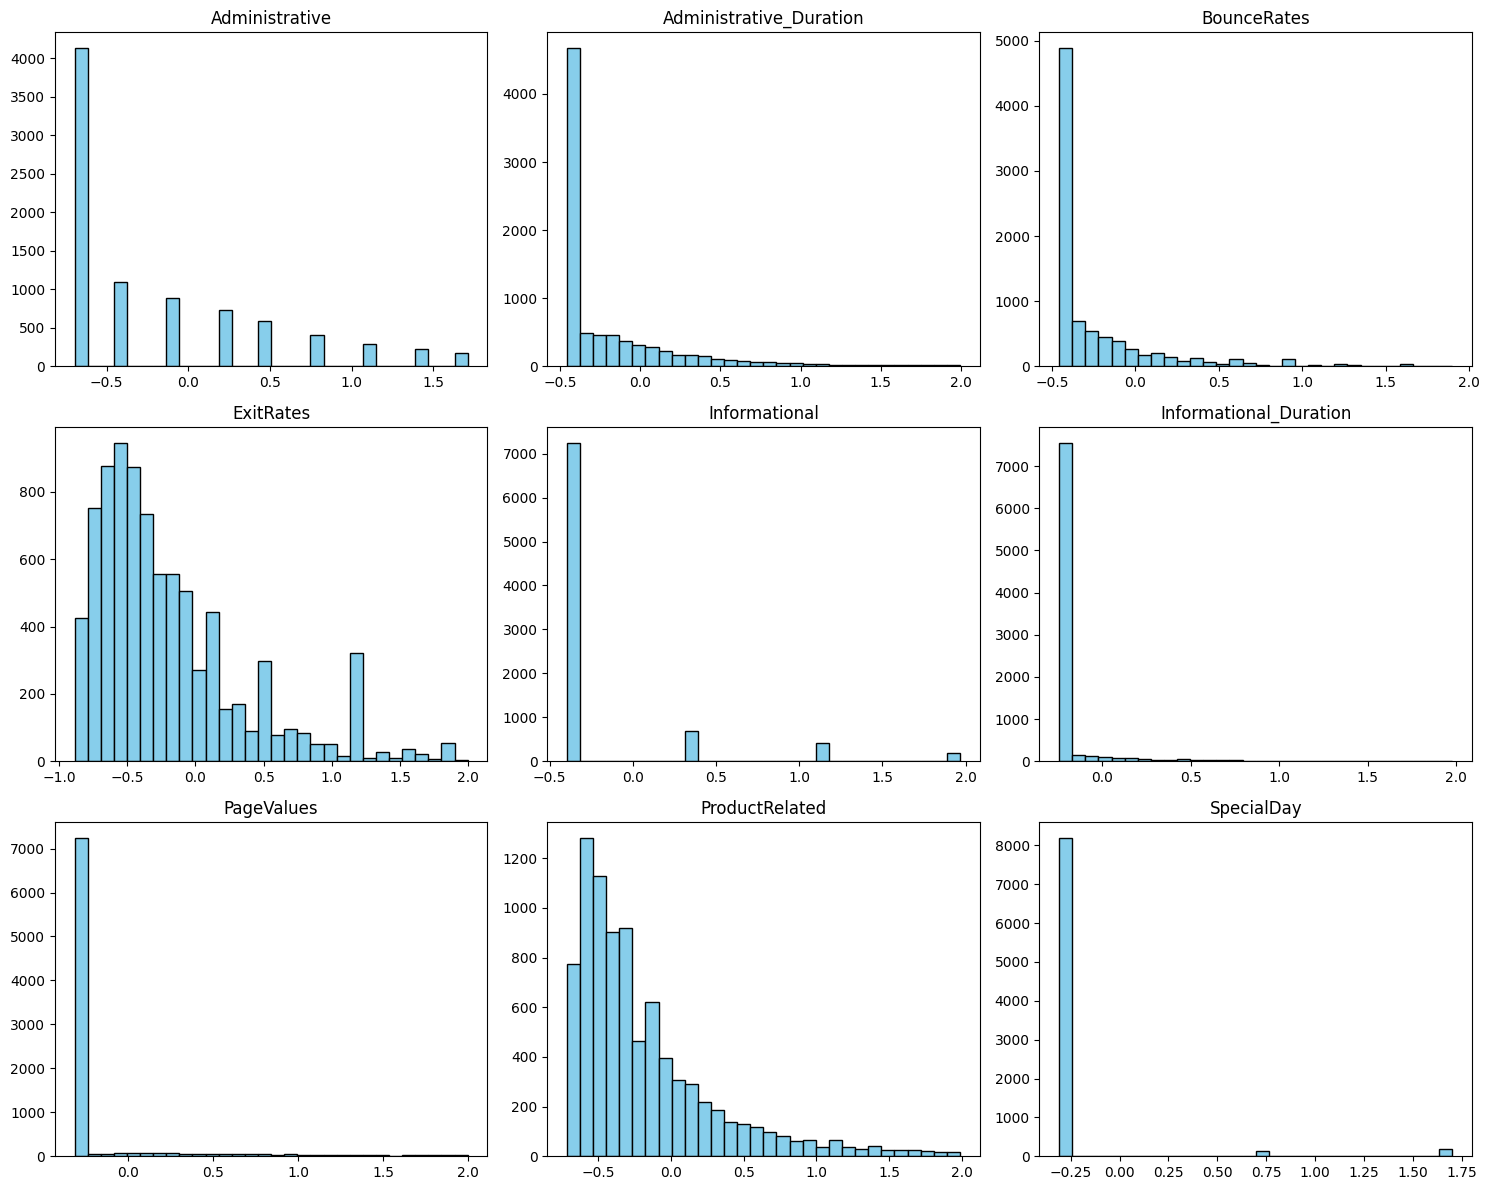

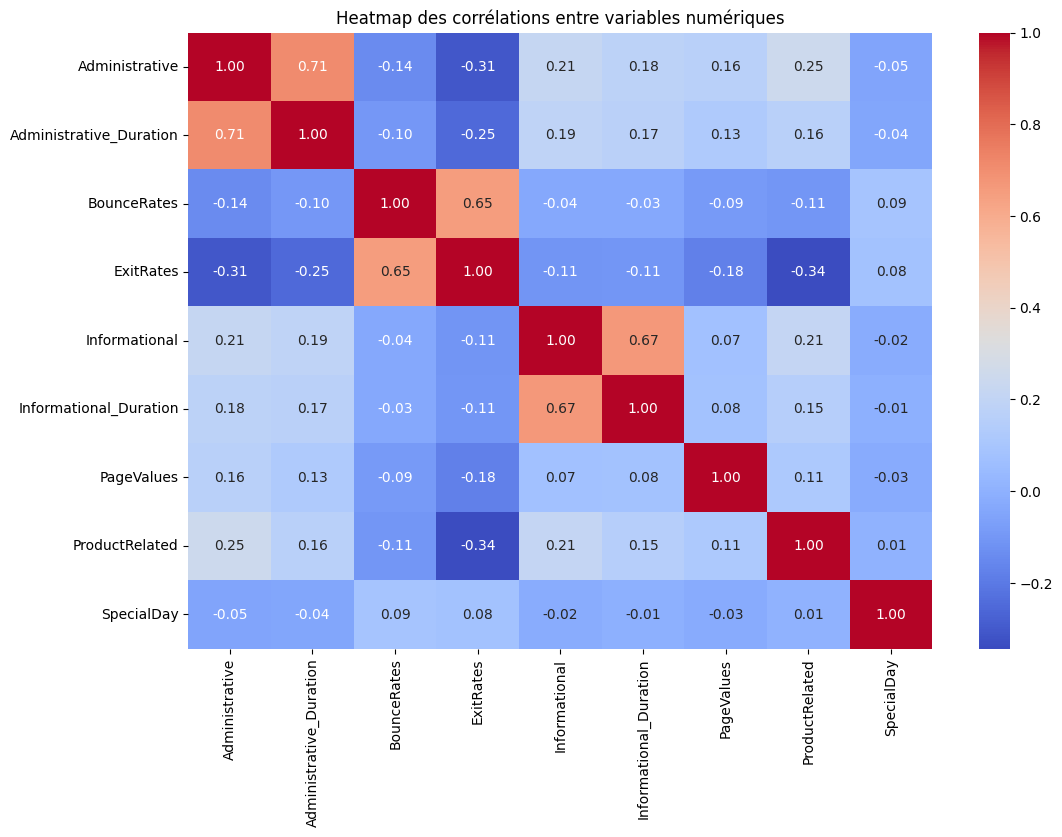

In [17]:

vars_hist = [col for col in numeric_cols if col != 'ProductRelated_Duration']

n = len(vars_hist)
ncols = 3
nrows = math.ceil(n / ncols)

plt.figure(figsize=(5 * ncols, 4 * nrows))
for i, col in enumerate(vars_hist, 1):
    plt.subplot(nrows, ncols, i)
    plt.hist(df_filtered[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.tight_layout()
plt.show()

# Heatmap des corrélations
plt.figure(figsize=(12, 8))
corr = df_filtered[vars_hist].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap des corrélations entre variables numériques")
plt.show()

In [18]:
df_encoded = pd.get_dummies(df_filtered, columns=var_categ, drop_first=True)

In [19]:
df_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,False,False,False,False,False,False,False,False,True,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,False,False,False,False,False,False,False,False,True,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,False,False,False,False,False,False,False,False,True,True
5,-0.696993,-0.457191,-0.396478,-0.244931,-0.286270,-0.543757,-0.132035,-0.380935,-0.317178,-0.308821,...,False,False,False,False,False,False,False,False,True,False
9,-0.696993,-0.457191,-0.396478,-0.244931,-0.646033,-0.238685,-0.457683,-0.429072,-0.317178,1.702146,...,False,False,False,False,False,False,False,False,True,False


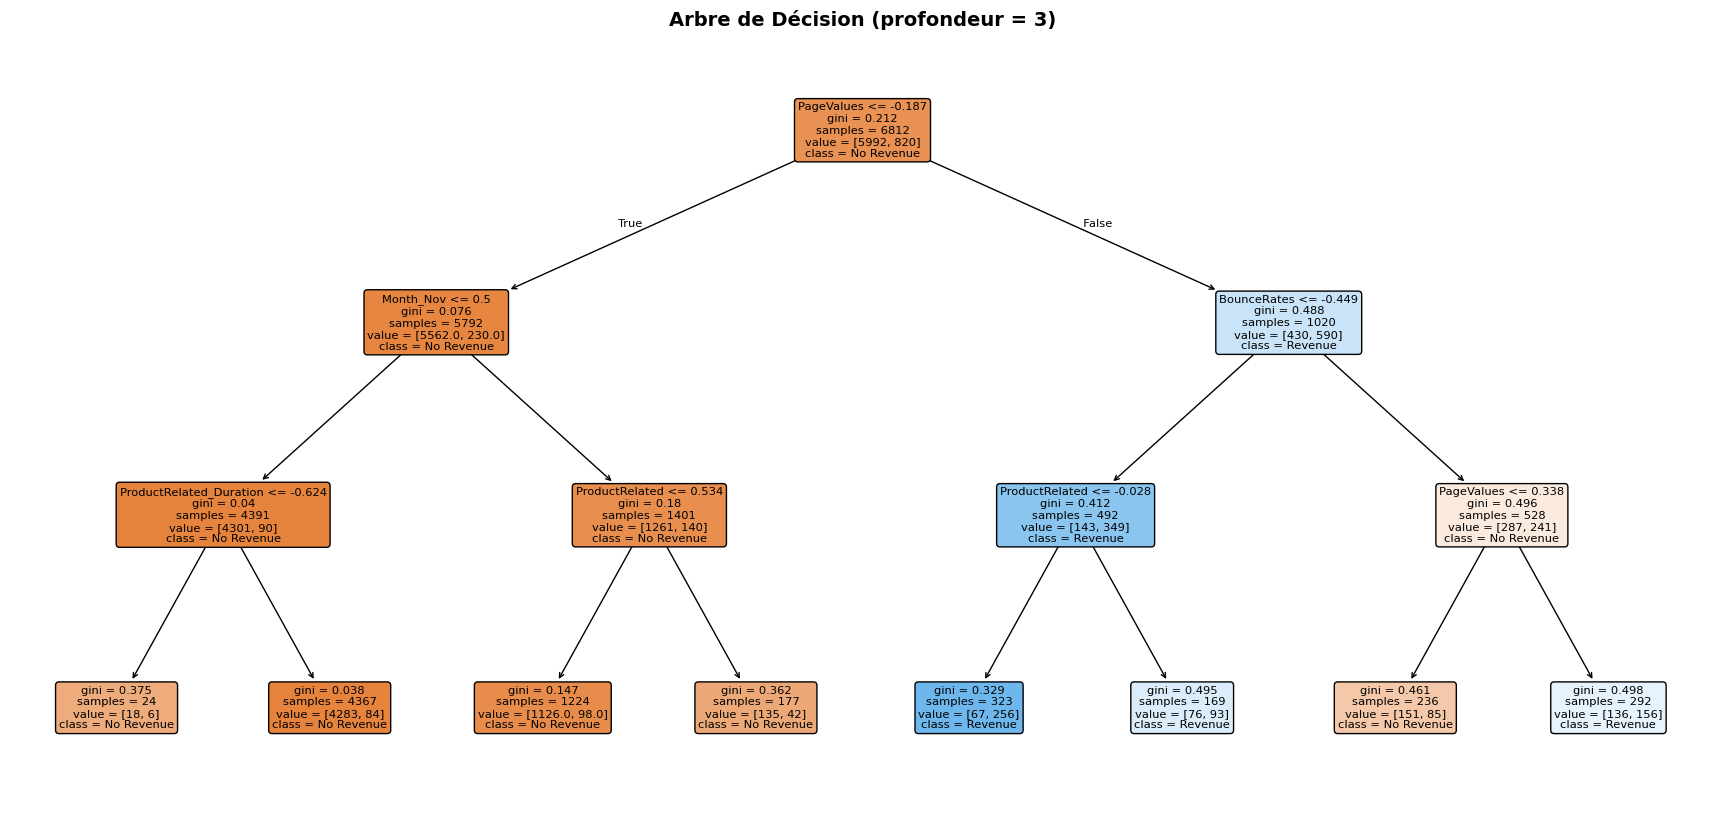

Accuracy : 0.9084507042253521
Matrice de confusion :
 [[1433   66]
 [  90  115]]
F1-score : 0.5958549222797928
Recall : 0.5609756097560976
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1499
           1       0.64      0.56      0.60       205

    accuracy                           0.91      1704
   macro avg       0.79      0.76      0.77      1704
weighted avg       0.90      0.91      0.91      1704



In [20]:

# Données
X = df_encoded.drop(columns='Revenue')
y = df_encoded['Revenue'].astype(int)

# Découpage train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2003, stratify=y)

# Entraînement de l’arbre de décision
clf_filt = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_filt.fit(X_train, y_train)

# Affichage de l’arbre avec noms de variables
plt.figure(figsize=(22, 10))
plot_tree(clf_filt,
          feature_names=X.columns,
          class_names=['No Revenue', 'Revenue'],
          filled=True,
          rounded=True)
plt.title("Arbre de Décision (profondeur = 3)", fontsize=14, fontweight="bold")
plt.show()

# Prédictions sur le jeu de test
y_pred = clf_filt.predict(X_test)

# Métriques
acc_filt = accuracy_score(y_test, y_pred)
cm_filt = confusion_matrix(y_test, y_pred)
f1_filt = f1_score(y_test, y_pred)
rec_filt = recall_score(y_test, y_pred)

# Affichage des résultats
print("Accuracy :", acc_filt)
print("Matrice de confusion :\n", cm_filt)
print("F1-score :", f1_filt)
print("Recall :", rec_filt)
print(classification_report(y_test, y_pred))


In [21]:

# Paramètres à tester pour le GridSearch
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200]
}

mlp = MLPClassifier(random_state=42)
grid = GridSearchCV(mlp, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score F1 :", grid.best_score_)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

Meilleurs paramètres : {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}
Meilleur score F1 : 0.5997737872844268


In [22]:

# Création du modèle MLPClassifier avec les meilleurs paramètres trouvés par GridSearchCV
best_mlp = MLPClassifier(random_state=42, **grid.best_params_)
best_mlp.fit(X_train, y_train)

# Prédictions sur l'ensemble d'apprentissage
y_test_pred = best_mlp.predict(X_test)

# Affichage des métriques


cm_nn = confusion_matrix(y_test, y_test_pred)
f1_nn = f1_score(y_test, y_test_pred)
rec_nn = recall_score(y_test, y_test_pred)
acc_nn = accuracy_score(y_test, y_test_pred)

print("Matrice de confusion :\n", cm_nn)
print("F1-score :", f1_nn)
print("Recall :", rec_nn)
print("Accuracy :", acc_nn)


print(classification_report(y_test, y_test_pred))
print(f"AUC : {roc_auc_score(y_test, y_test_pred):.4f}")

Matrice de confusion :
 [[1453   46]
 [ 108   97]]
F1-score : 0.5574712643678161
Recall : 0.47317073170731705
Accuracy : 0.9096244131455399
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1499
           1       0.68      0.47      0.56       205

    accuracy                           0.91      1704
   macro avg       0.80      0.72      0.75      1704
weighted avg       0.90      0.91      0.90      1704

AUC : 0.7212


In [35]:
# Prédictions des probabilités pour la classe positive (Revenue = 1)
y_proba_nn = best_mlp.predict_proba(X_test)[:, 1]


In [23]:


# Définition de la grille d’hyperparamètres
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']  # important pour dataset déséquilibré
}

# Initialisation du modèle
rf_base = RandomForestClassifier(random_state=2003)

# GridSearchCV avec validation croisée 5-fold
grid_search = GridSearchCV(estimator=rf_base,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Entraînement du modèle avec recherche des meilleurs hyperparamètres
grid_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search.best_params_)

# Utilisation du meilleur modèle pour prédire
best_rf = grid_search.best_estimator_
y_rf_pred = best_rf.predict(X_test)

# Évaluation
print("Matrice de confusion :\n", confusion_matrix(y_test, y_rf_pred))
print("F1-score :", f1_score(y_test, y_rf_pred))
print("Recall :", recall_score(y_test, y_rf_pred))
print("Accuracy :", accuracy_score(y_test, y_rf_pred))
print(classification_report(y_test, y_rf_pred))
print(f"AUC : {roc_auc_score(y_test, y_rf_pred):.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs paramètres : {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Matrice de confusion :
 [[1425   74]
 [  91  114]]
F1-score : 0.5801526717557252
Recall : 0.5560975609756098
Accuracy : 0.903169014084507
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1499
           1       0.61      0.56      0.58       205

    accuracy                           0.90      1704
   macro avg       0.77      0.75      0.76      1704
weighted avg       0.90      0.90      0.90      1704

AUC : 0.7534


In [30]:
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]


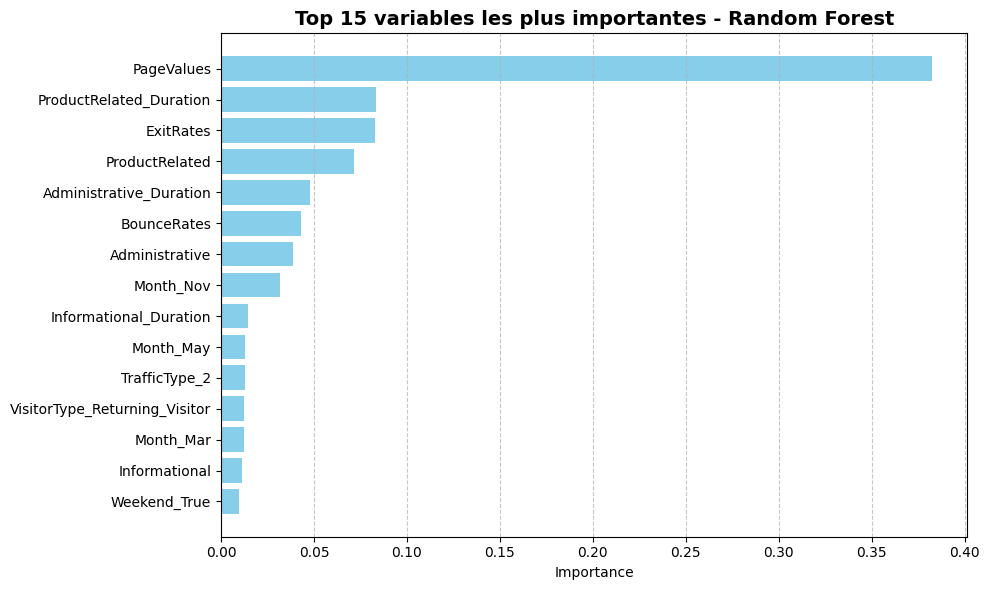

In [24]:
importances = best_rf.feature_importances_
 
# Si tu as les noms de colonnes (X_nn est un DataFrame)
feature_names = X.columns if hasattr(X, 'columns') else [f'Var{i}' for i in range(X.shape[1])]
 
# Construction d'un DataFrame pour trier les importances
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)
 
# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][::-1], feat_imp_df['Importance'][::-1], color='skyblue')
plt.title("Top 15 variables les plus importantes - Random Forest", fontsize=14, fontweight='bold')
plt.xlabel("Importance")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs paramètres : {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
🔍 Régression Logistique optimisée
              precision    recall  f1-score   support

           0       0.95      0.88      0.92      1499
           1       0.44      0.68      0.54       205

    accuracy                           0.86      1704
   macro avg       0.70      0.78      0.73      1704
weighted avg       0.89      0.86      0.87      1704

AUC : 0.8802


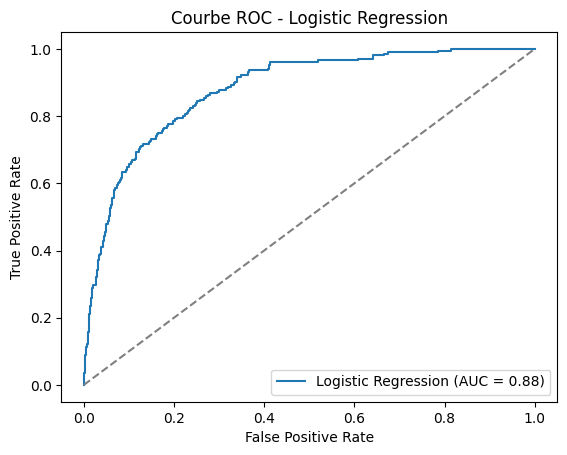

In [25]:

# Grille de recherche des hyperparamètres
param_grid = {
    'penalty': ['l2'],  # L1 nécessite solver='liblinear' ou 'saga'
    'C': [0.01, 0.1, 1, 10],  # Inverse de la régularisation
    'solver': ['lbfgs'],      # Compatible avec penalty='l2'
    'class_weight': ['balanced']
}

# GridSearchCV avec scoring AUC ou F1
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=2003),
                              param_grid=param_grid,
                              scoring='f1',
                              cv=5,
                              n_jobs=-1,
                              verbose=1)

# Entraînement
grid_search_lr.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", grid_search_lr.best_params_)

# Prédictions avec le meilleur modèle
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# Évaluation
print("🔍 Régression Logistique optimisée")
print(classification_report(y_test, y_pred_lr))
print(f"AUC : {roc_auc_score(y_test, y_proba_lr):.4f}")

# Courbe ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression (AUC = %.2f)" % roc_auc_score(y_test, y_proba_lr))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC - Logistic Regression")
plt.legend()
plt.show()


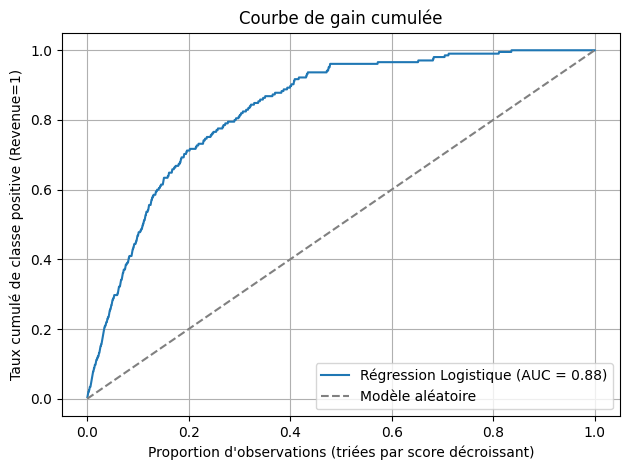

In [32]:
def plot_gain_curve(y_true, y_proba, label="Modèle"):
    # Tri des probabilités en ordre décroissant
    sorted_indices = np.argsort(y_proba)[::-1]
    y_sorted = np.array(y_true)[sorted_indices]

    # Calcul du gain cumulatif
    cum_gains = np.cumsum(y_sorted) / y_sorted.sum()
    percents = np.arange(1, len(cum_gains)+1) / len(cum_gains)

    # Tracé
    plt.plot(percents, cum_gains, label=f"{label} (AUC = {roc_auc_score(y_true, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], '--', color='gray', label="Modèle aléatoire")
    plt.xlabel("Proportion d'observations (triées par score décroissant)")
    plt.ylabel("Taux cumulé de classe positive (Revenue=1)")
    plt.title("Courbe de gain cumulée")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

# Utilisation avec ton modèle logistique
plot_gain_curve(y_test, y_proba_lr, label="Régression Logistique")
plt.show()

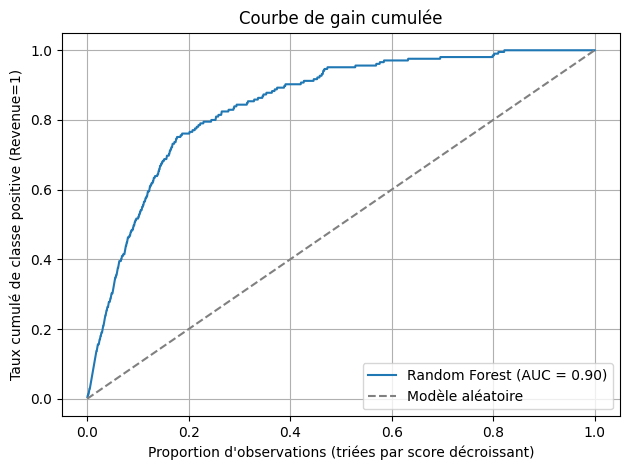

In [34]:
plot_gain_curve(y_test, y_proba_rf, label="Random Forest")
plt.show()

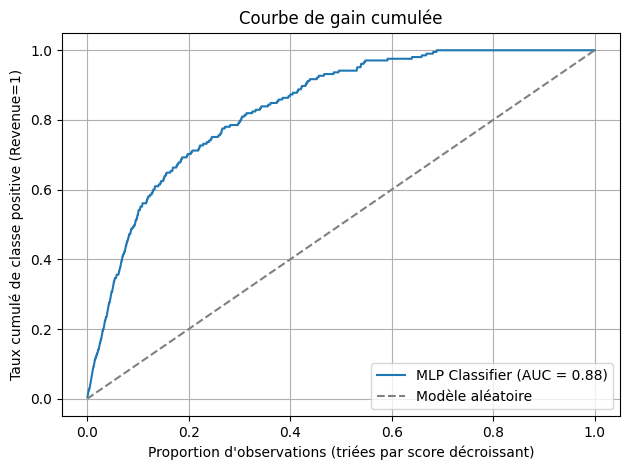

In [36]:
plot_gain_curve(y_test, y_proba_nn, label="MLP Classifier")
plt.show()